In [1]:
%matplotlib notebook 
# Import modules
import math
import numpy as np
import matplotlib.pyplot
from matplotlib.ticker import FormatStrFormatter
import tables as tb
from pyne import data
import itertools
import re
import os

markers=itertools.cycle(('o','v','s','^','<','>','p','P','*','h','H','+','x','X','D','d','|','_'))

iso_list = ['Xe135', 'Te135','Kr83', 'I135','U235', 'U236', 'U238', 'Pu238','Pu239', 'Pu240', 'Pu241', 'Pu242', 'Am241', 'Am242', 'H3', 'He4']
colors = matplotlib.pyplot.rcParams['axes.prop_cycle'].by_key()['color']

def merge(a,b):
    final = np.zeros (len(a)+len(b))
    for i in range(len(a)):
        final[2*i]   = a[i]
        final[2*i+1] = b[i]
    return final

def elem_aaa(iso):
    m = re.match(r"(?P<letters>[a-zA-Z]+)(?P<the_rest>.+)$", iso)
    return [m.group('letters'), m.group('the_rest')]

def read_keff_h5(file):
    db = tb.open_file(file, mode='r')
    sim_param = db.root.simulation_parameters
    init_param = db.root.initial_depcode_siminfo
    # Keff at t=0 depletion step
    k_0 = np.array([x['keff_bds'][0] for x in sim_param.iterrows()])
    k_0_e = np.array([x['keff_bds'][1] for x in sim_param.iterrows()])
    # Keff at t=end depletion step
    k_1 = np.array([x['keff_eds'][0] for x in sim_param.iterrows()])
    k_1_e = np.array([x['keff_eds'][1] for x in sim_param.iterrows()])
    # Power level
    power = np.array([x['power_level'] for x in sim_param.iterrows()])
    day_eds = np.array([x['cumulative_time_at_eds'] for x in sim_param.iterrows()])
    day_bds = np.zeros_like(day_eds)
    for i in range(1, len(day_eds)):
        day_bds[i] = day_eds[i] - (day_eds[i] - day_eds[i-1])
    db.close()
    return np.around(day_bds*24.0,decimals=2), np.around(day_eds*24.0, decimals=2), k_0, k_1, k_0_e, k_1_e, power

def read_iso_m_h5(db_file, iso_list):
    db = tb.open_file(db_file, mode='r')
    fuel_bef_mat = db.root.materials.fuel.before_reproc.parameters
    fuel_bef = db.root.materials.fuel.before_reproc.comp
    isomap = fuel_bef.attrs.iso_map

    fuel_after_mat = db.root.materials.fuel.after_reproc.parameters
    fuel_after = db.root.materials.fuel.after_reproc.comp

    mass_b = np.array([x['mass'] for x in fuel_bef_mat.iterrows()])
    vol_b = np.array([x['volume'] for x in fuel_bef_mat.iterrows()])
    dens_b = np.array([x['density'] for x in fuel_bef_mat.iterrows()])

    mass_a = np.array([x['mass'] for x in fuel_after_mat.iterrows()])
    vol_a = np.array([x['volume'] for x in fuel_after_mat.iterrows()])
    dens_a = np.array([x['density'] for x in fuel_after_mat.iterrows()])

    mass_b = {}
    mass_a = {}
    for iso in iso_list:
        mass_b[iso] = 1e-6*np.array([row[isomap[iso]] for row in fuel_bef])
        mass_a[iso] = 1e-6*np.array([row1[isomap[iso]] for row1 in fuel_after])
    
    sim_param = db.root.simulation_parameters
    day_eds = np.array([x['cumulative_time_at_eds'] for x in sim_param.iterrows()])
    day_bds = np.zeros_like(day_eds)
    for i in range(1, len(day_eds)):
        day_bds[i] = day_eds[i] - (day_eds[i] - day_eds[i-1])
    db.close()
    return np.around(day_bds*24.0,decimals=2), np.around(day_eds*24.0, decimals=2),mass_b, mass_a  # mass in tonnes

/home/andrei2/anaconda3/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)


In [2]:
moment = itertools.cycle(('BOL', '15 years','30 years'))
t_indx_shutdown = 0
# Epsilon=91%, K_L=100ft/hr
file_list = ['../../msbr/load-following/large_eps/bol/msbr_lf_kl_100_bol.h5',
             '../../msbr/load-following/large_eps/mol/msbr_lf_kl_100_mol.h5',
             '../../msbr/load-following/large_eps/eol/msbr_lf_kl_100_eol_before_repro.h5'
            ]

#moment = itertools.cycle((r'$\epsilon_{Xe}=0.915$', r'$\epsilon_{Xe}=0.536$'))
#file_list = ['../../msbr/load-following/large_eps/bol/msbr_lf_kl_100_bol.h5',
#             '../../msbr/load-following/mid_eps/bol/msbr_lf_kl_25_bol.h5'
#            ]


# EOL
#db_file = os.path.join(os.getcwd(), '../../msbr/load-following/large_eps/eol/msbr_lf_kl_100_eol_before_repro.h5')
#db_file = os.path.join(os.getcwd(), '../../msbr/load-following/large_eps/eol/msbr_lf_kl_100_eol_after.h5')

# MOL
#db_file = os.path.join(os.getcwd(), '../../msbr/load-following/large_eps/mol/msbr_lf_kl_100_mol.h5')
# BOL
# db_file = os.path.join(os.getcwd(), '../../msbr/load-following/large_eps/bol/msbr_lf_kl_100_bol.h5')
# Epsilon = 3%, K_L=1ft/hr
# db_file = os.path.join(os.getcwd(), '../../load-following/small_eps_saltproc/eol/eoc/lf_kl_1_eol_eoc_after.h5')

#t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err, power = read_keff_h5(db_file)
#mass_before, mass_after = read_iso_m_h5(db_file, iso_list)
#t_comp = np.append(t_bds, t_eds[-1])

#t_eds = np.insert(t_eds, 0, 0.0)
#k_eds = np.insert(k_eds, 0, k_bds[0])
#k_eds_err = np.insert(k_eds_err, 0, k_eds_err[0])

#t_indx_shutdown = 0

# Epsilon=3%, K_L=1ft/hr
#db_file_void_5 = os.path.join(os.getcwd(), '../../db/long_term_eps_var/eps_3_kl_1.h5')
#t_bds_5, t_eds_5, k_bds_5, k_eds_5, k_bds_err_5, k_eds_err_5 = read_keff_h5(db_file_void_5)
#mass_before_5, mass_after_5 = read_iso_m_h5(db_file_void_5, iso_list)
#t_comp_5 = np.append(t_bds_5, t_eds_5[-1])

# Epsilon=53%, K_L=25ft/hr
#db_file_50 = os.path.join(os.getcwd(), '../../db/long_term_eps_var/eps_50_kl_25.h5')
#t_bds_50, t_eds_50, k_bds_50, k_eds_50, k_bds_err_50, k_eds_err_50 = read_keff_h5(db_file_50)
#mass_before_50, mass_after_50 = read_iso_m_h5(db_file_50, iso_list)
#t_comp_50 = np.append(t_bds_50, t_eds_50[-1])

<IPython.core.display.Javascript object>


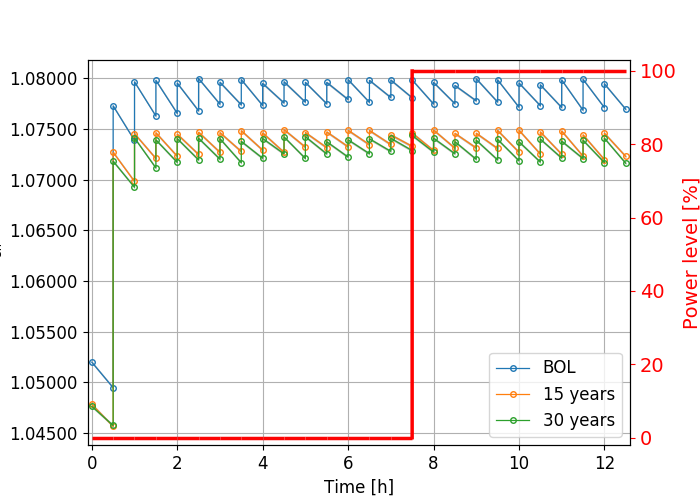

In [3]:
# Initialize figure
fig_keff = matplotlib.pyplot.figure(1, figsize=(7,5))
ax1 = fig_keff.add_subplot(111)
ax1.grid(True)
for file in file_list:
    m=next(moment)
    db_file = os.path.join(os.getcwd(), file)
    t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err, power = read_keff_h5(db_file)    
    keff = merge(k_bds, k_eds)
    t = merge(t_bds, t_eds)
    err = merge(k_bds_err, k_eds_err)
    #ax1.plot(t_bds, k_bds, 'o-', label=r'$K_L$=8.4667 mm/s (BDS)', linewidth=0.9, alpha=0.8, markerfacecolor="None")
    #ax1.plot(t_eds, k_eds, 's-', label=m, linewidth=0.9, alpha=0.8, markerfacecolor="None")
    ax1.plot(t, keff, 'o-', label=m, linewidth=0.9, alpha=1, markerfacecolor="None", markersize=4)
    ax1.fill_between(t, keff-err, keff+err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)
    #ax1.fill_between(t_eds, k_eds-k_eds_err, k_eds+k_eds_err, edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)



ax1.legend(loc=0, fontsize=12)
ax1.set_ylabel(r'$k_{eff}$', fontsize=12)
ax1.set_xlabel('Time [h]', fontsize=12)
ax1.set_xlim(-0.1,12.6)
ax1.tick_params('x', labelsize=12)
# ax1.set_xticks(days_tap)
ax1.tick_params('y', labelsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge', 
        width=t_bds[1]-t_bds[0], ls="-", edgecolor='#fc0303', linewidth=2.5, fill=False)
ax2.plot([7.5,7.5001],[0, 100], c='red', alpha=1, linewidth=2.5)
ax2.set_ylim(-2,103)
ax2.set_ylabel('Power level [%]', color='r', fontsize=14)
ax2.tick_params('y', colors='r', labelsize=14)


fig_keff.show()
#fig_keff.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch6/kl100_keff.png',bbox_inches='tight', dpi=900)

<IPython.core.display.Javascript object>


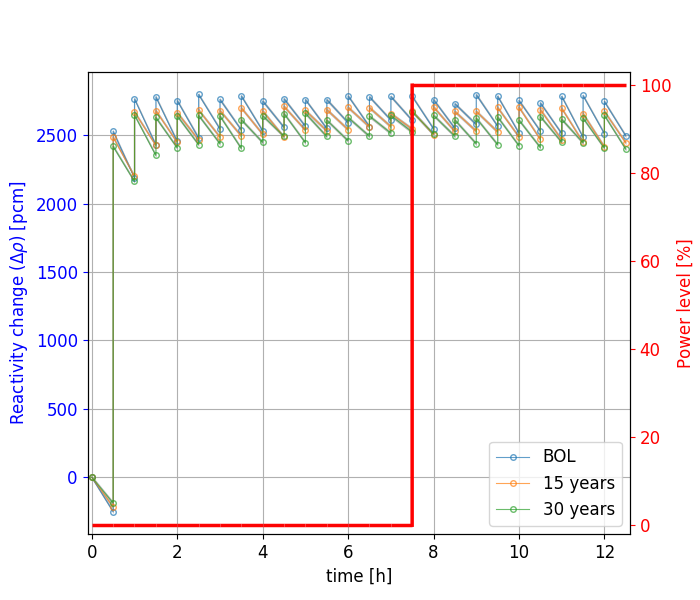

Maximum reactivity drop 0.000000 pcm
Maximum reactivity spike 2713.000732 pcm


In [4]:
fig_rho = matplotlib.pyplot.figure(2, figsize=(7,6))
ax1 = fig_rho.add_subplot(111)
ax1.grid(True)
for file in file_list:
    m=next(moment)
    db_file = os.path.join(os.getcwd(), file)
    t_bds, t_eds, k_bds, k_eds, k_bds_err, k_eds_err, power = read_keff_h5(db_file)    
    keff = merge(k_bds, k_eds)
    t = merge(t_bds, t_eds)
    err = merge(k_bds_err, k_eds_err)
    ax1.plot(t, 1e+5*(keff-keff[t_indx_shutdown]), 'o-', label=m, linewidth=0.8, alpha=0.7, markerfacecolor="None", markersize=4)
    ax1.fill_between(t, 1e+5*(keff-keff[t_indx_shutdown]-err), 1e+5*(keff-keff[t_indx_shutdown]+err), edgecolor='#808080', facecolor='#BEBEBE', linewidth=0.1)


ax1.legend(loc=0, fontsize=12)
ax1.set_ylabel(r'Reactivity change ($\Delta\rho$) [pcm]', color='b', fontsize=12)
ax1.set_xlabel('time [h]', fontsize=12)
ax1.set_xlim(-0.1,12.6)
ax1.tick_params('x', labelsize=12)
#ax1.set_xticks(t_eds)
ax1.tick_params('y', colors='b',labelsize=12)
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%.5f'))

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge',
        width=t_bds[1]-t_bds[0], ls="-",edgecolor='#fc0303', linewidth=2.5, fill=False)
ax2.plot([7.5,7.5001],[0, 100], c='red', alpha=1, linewidth=2.5)
ax2.set_ylim(-2,103)
ax2.set_ylabel('Power level [%]', color='r', fontsize=12)
ax2.tick_params('y', colors='r', labelsize=12)


fig_rho.show()
#fig_rho.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch6/kl100_rho.png',bbox_inches='tight', dpi=700)
print('Maximum reactivity drop %f pcm' %(np.amin(1e+5*(k_eds-k_eds[0]))))
print('Maximum reactivity spike %f pcm' %(np.amax(1e+5*(k_eds-k_eds[t_indx_shutdown]))))

<IPython.core.display.Javascript object>


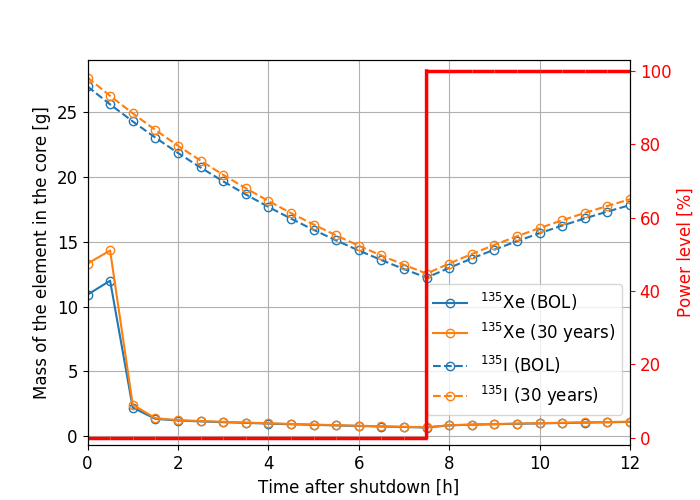

In [5]:
#plot_iso = ['He4']
#plot_iso = ['U235','U238']
plot_iso = ['Xe135', 'I135']
#print(len(t_comp[:3001]), len(t_comp_5))
moment = itertools.cycle(('BOL', '30 years'))
line_st = itertools.cycle(('o-', 'o--'))

# Initialize figure
fig_comp = matplotlib.pyplot.figure(3, figsize=[7,5])
ax1 = fig_comp.subplots()
ax1.grid(True)

for i in plot_iso:
    lin=next(line_st)
    ax1.set_prop_cycle(color=colors[0:])
    el_aaa = elem_aaa(i)
    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
    for file in [file_list[0], file_list[-1]]:
        mom=next(moment)
        db_file = os.path.join(os.getcwd(), file)
        t_bds, t_eds, mass_before, mass_after = read_iso_m_h5(db_file, [i])
        t_comp = np.append(t_bds, t_eds[-1])
        ax1.plot(t_comp, 1e6*mass_before[i], lin, label=str(k_name)+' ('+mom+')', linewidth=1.5, markerfacecolor='none')


#ax1.set_prop_cycle(color=colors[0:])
#for i in plot_iso:
#    m=next(markers)
#    el_aaa = elem_aaa(i)
#    k_name = "$^{"+str(el_aaa[-1])+"}$"+str(el_aaa[0])
#    ax1.plot(t_comp[1:], 1e6*mass_after[i], '+--', label=str(k_name)+' after ($K_L$=8.4667 mm/s)', linewidth=1.5, alpha=0.5)
    # ax1.plot(t_comp_50[1:]/365.0, mass_after_50[i], '-.', label=str(k_name)+' after ($K_L$=2.1167 mm/s)', color='g', linewidth=1.5)
    # ax1.plot(t_comp_5[1:]/365.0, mass_after_5[i], '-.', label=str(k_name)+' after ($K_L$=0.0847 mm/s)', color='r', linewidth=1.5)
    

ax1.legend(loc=2, bbox_to_anchor=(0.61, 0.44), fontsize=12)
#ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.tick_params('y', labelsize=12)
ax1.tick_params('x', labelsize=12)
ax1.set_ylabel('Mass of the element in the core [g]', fontsize=12)
ax1.set_xlabel('Time after shutdown [h]', fontsize=12)
#ax.set_title('Multiplication factor for online reprocessing case ' + str(EOS) +' days')
ax1.set_xlim(0, 12)
#ax1.set_ylim(0, 7)
#ax1.set_ylim(2e-, 2.5e-5)

ax2=ax1.twinx()
ax2.bar(t_bds, 0.0, bottom=100*power/np.amax(power),color='#f77777', alpha=1, align='edge',
        width=t_bds[1]-t_bds[0], ls="-",edgecolor='#fc0303', linewidth=2.5, fill=False)
ax2.plot([7.5,7.5001],[0, 100], c='red', alpha=1, linewidth=2.5)
ax2.set_ylim(-2,103)
ax2.set_ylabel('Power level [%]', color='r', fontsize=12)
ax2.tick_params('y', colors='r', labelsize=12)

fig_comp.show()
#fig_comp.savefig('/home/andrei2/Desktop/git/publications/2020-rykhl-dissertation/dissertation/figures/ch6/kl100_xe_i_ratio.png',bbox_inches='tight', dpi=700)

In [6]:
V = 4.43530000000000E+07 # cm3
NA = 6.02214076e23

db_file = os.path.join(os.getcwd(), file_list[1])
t_bds, t_eds, mass_before, mass_after = read_iso_m_h5(db_file, iso_list)

N_xe_0 = mass_before['Xe135'][0]
N_i_0 = mass_before['I135'][0]
N_te_0 = mass_before['Te135'][0]


lamb_xe = data.decay_const('Xe-135')
lamb_i = data.decay_const('I-135')
lamb_te = data.decay_const('Te-135')
10
nom = lamb_xe*(lamb_i*(N_xe_0+N_i_0)-lamb_xe*N_xe_0)
den = lamb_i**2 * N_i_0
t_peak = np.log(nom/den) / (lamb_xe-lamb_i)

print("Operative excees reactivity %f pcm" %(1e5*(k_eds[0]-1.0)))
print('Analytical solution for the Xe-135 peak %f s, %f h' %(t_peak, t_peak/3600))
print('I135/Xe135 ratio at the beginning of the transient %f' 
        %(N_i_0/N_xe_0))
print('Xe135 concentration peak %f [%%]' %(100*np.amax(mass_before['Xe135'])/N_xe_0))
print('Maximum reactivity change after shutdown %f pcm ' %(1e5*np.amin((k_eds-k_eds[t_indx_shutdown]))))

Operative excees reactivity 4572.999477 pcm
Analytical solution for the Xe-135 peak 25174.835310 s, 6.993010 h
I135/Xe135 ratio at the beginning of the transient 2.153016
Xe135 concentration peak 108.041379 [%]
Maximum reactivity change after shutdown 0.000000 pcm 
